# Notebook de cliente

In [1]:
from datasets import load_dataset
from model import NERClassifier
from preprocess_dataset import NERDataset 
from trainner import Trainner
from transformers import BertTokenizerFast
from preprocess_dataset import remove_empty_entries

import torch

## Setups

In [2]:
CHECKPOINT = 'neuralmind/bert-base-portuguese-cased'
tokenizer = BertTokenizerFast.from_pretrained(CHECKPOINT)

In [3]:
data = "lener_br"
dataset = load_dataset(data)
dataset = remove_empty_entries(dataset)

Reusing dataset lener_br (/home/caiotulio/.cache/huggingface/datasets/lener_br/lener_br/1.0.0/4a8c97e6813b5c2d85a50faf0a3e6c24ea82f4a9044e6e9e8b24997d27399382)
Loading cached processed dataset at /home/caiotulio/.cache/huggingface/datasets/lener_br/lener_br/1.0.0/4a8c97e6813b5c2d85a50faf0a3e6c24ea82f4a9044e6e9e8b24997d27399382/cache-5e59bc59f25f3d7f.arrow
Loading cached processed dataset at /home/caiotulio/.cache/huggingface/datasets/lener_br/lener_br/1.0.0/4a8c97e6813b5c2d85a50faf0a3e6c24ea82f4a9044e6e9e8b24997d27399382/cache-8d0457760cd67ee6.arrow
Loading cached processed dataset at /home/caiotulio/.cache/huggingface/datasets/lener_br/lener_br/1.0.0/4a8c97e6813b5c2d85a50faf0a3e6c24ea82f4a9044e6e9e8b24997d27399382/cache-74e841c1c151996a.arrow


In [4]:
MAX_LEN = 128
n_labels = 13 #TODO: por enquanto hardcodado 

In [5]:
pytorch_dataset_train = NERDataset(data=dataset['train'], max_len=MAX_LEN, tokenizer=tokenizer)
teste = pytorch_dataset_train[0]

In [6]:
model = NERClassifier(n_labels=n_labels, checkpoint=CHECKPOINT)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model check

----------------------------------------

## Treinando o modelo

Usando parametros padrão por enquanto só pra ver se ta tudo indo certindo

In [7]:
from trainner import Trainner, create_data_loader
from transformers import AdamW
from torch.utils.data import DataLoader
from evaluator import Evaluator

### Parametros


* batch sizes: 8, 16, 32, 64, 128
* learning rates: 3e-4, 1e-4, 5e-5, 3e-5

Do paper do BERT. Vou colocar num_workers = 4 por enquanto.


Uma melhoria é esconder o data_loader de clientes. Isso é detalhe de implementaçãõ, ou deveria estar na classe NERDataset

In [8]:
optimizer = AdamW(model.parameters(), lr=3e-4, correct_bias=False)

In [9]:
len(pytorch_dataset_train)

7827

In [10]:
loader = DataLoader(pytorch_dataset_train, batch_size=8, shuffle=True)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
next(model.parameters()).is_cuda

False

In [13]:
pytorch_dataset_train = NERDataset(data=dataset['train'], max_len=MAX_LEN, tokenizer=tokenizer)

In [14]:
pytorch_dataset_test = NERDataset(data=dataset['test'], max_len=MAX_LEN, tokenizer=tokenizer)

In [15]:
ds_train = DataLoader(pytorch_dataset_train, batch_size=8, shuffle=True)

In [16]:
ds_test = DataLoader(pytorch_dataset_test, batch_size=8, shuffle=True)

In [17]:
num_epochs = 8

In [18]:
evaluator = Evaluator(ds_test, model, device)

In [19]:
tr = Trainner(device, loader, model, optimizer, max_len=128, num_examples=len(pytorch_dataset_train), num_epochs=num_epochs, evaluator=evaluator)

In [20]:
%%time
losses_t, losses_e, f1_e, f1_t = tr.train()

Começando treino! Essa função retorna a media de f1 e loss em cada epoch de treino e avaliação
----------Começando treino da epoch nº 1
Treinando em cuda
Iteração 0 -------- Loss: 2.5394721031188965 f1 nas ultimas 100 iterações: 0.0012145969615536974 ------ Progresso: 0.00%.
Iteração 100 -------- Loss: 0.37204670906066895 f1 nas ultimas 100 iterações: 0.7993796532522692 ------ Progresso: 10.21%.
Iteração 200 -------- Loss: 0.8804038166999817 f1 nas ultimas 100 iterações: 0.808106457246636 ------ Progresso: 20.43%.
Iteração 300 -------- Loss: 1.0385022163391113 f1 nas ultimas 100 iterações: 0.814527222724851 ------ Progresso: 30.64%.
Iteração 400 -------- Loss: 0.17376753687858582 f1 nas ultimas 100 iterações: 0.8093923692864309 ------ Progresso: 40.86%.
Iteração 500 -------- Loss: 1.1292165517807007 f1 nas ultimas 100 iterações: 0.8154637939934029 ------ Progresso: 51.07%.
Iteração 600 -------- Loss: 0.2924439311027527 f1 nas ultimas 100 iterações: 0.8218006633481797 ------ Progresso: 

## Performance ao longo de 8 épocas

In [21]:
from matplotlib import pyplot as plt
import numpy as np

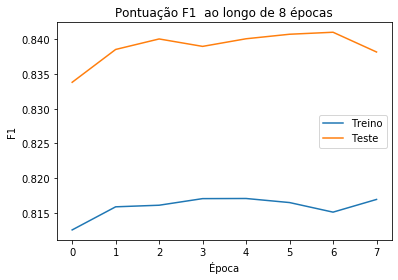

In [22]:
plt.plot(f1_t, label="Treino")

plt.plot(f1_e, label="Teste")
plt.title("Pontuação F1  ao longo de 8 épocas")
plt.xlabel("Época")
plt.ylabel("F1")

plt.legend()
plt.show()

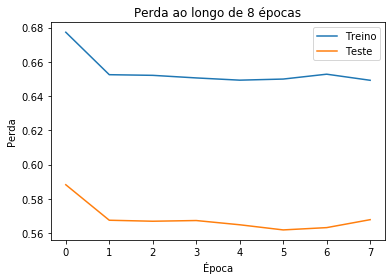

In [23]:
plt.plot(losses_t, label="Treino")

plt.plot(losses_e, label="Teste")
plt.title("Perda ao longo de 8 épocas")
plt.xlabel("Época")
plt.ylabel("Perda")

plt.legend()
plt.show()

## Analisando 1 época

In [24]:
model = NERClassifier(n_labels=n_labels, checkpoint=CHECKPOINT) # Reloads model
tr = Trainner(device, loader, model, optimizer, max_len=128, num_examples=len(pytorch_dataset_train), num_epochs=num_epochs, evaluator=evaluator)

Some weights of the model checkpoint at neuralmind/bert-base-portuguese-cased were not used when initializing BertForTokenClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model check

In [25]:
%%time
loss_t, f1 = tr._train_epoch()

Treinando em cuda
Iteração 0 -------- Loss: 2.59131121635437 f1 nas ultimas 100 iterações: 0.0009917835264059462 ------ Progresso: 0.00%.
Iteração 100 -------- Loss: 2.5617434978485107 f1 nas ultimas 100 iterações: 0.12153685306857645 ------ Progresso: 10.21%.
Iteração 200 -------- Loss: 2.597963809967041 f1 nas ultimas 100 iterações: 0.12778299320111264 ------ Progresso: 20.43%.
Iteração 300 -------- Loss: 2.5596866607666016 f1 nas ultimas 100 iterações: 0.1203023237712582 ------ Progresso: 30.64%.
Iteração 400 -------- Loss: 2.583043098449707 f1 nas ultimas 100 iterações: 0.12831207968660074 ------ Progresso: 40.86%.
Iteração 500 -------- Loss: 2.620967388153076 f1 nas ultimas 100 iterações: 0.11657694320580063 ------ Progresso: 51.07%.
Iteração 600 -------- Loss: 2.5347561836242676 f1 nas ultimas 100 iterações: 0.1197441668823278 ------ Progresso: 61.29%.
Iteração 700 -------- Loss: 2.571058988571167 f1 nas ultimas 100 iterações: 0.12705906420327198 ------ Progresso: 71.50%.
Iteraçã

In [26]:

loss_e, f1_e = tr.evaluate()

Iteração 100 -------- Loss: 0.8434559106826782 f1 nas ultimas 100 iterações: 0.8440430700327204 ------ Progresso: 57.47%.


In [27]:

def smooth(y, box_pts):
    box = np.ones(box_pts)/box_pts
    y_smooth = np.convolve(y, box, mode='same')
    return y_smooth

In [28]:
f1

[0.09917835264059462,
 0.13116816008868157,
 0.12143050767024904,
 0.07570024639610298,
 0.08571382786084002,
 0.10624399092970523,
 0.06552930786316184,
 0.14502700633299662,
 0.15418925410004802,
 0.10620471113881048,
 0.1199457574583495,
 0.24854819976771195,
 0.11099522169053581,
 0.10074152308292436,
 0.1545855513307985,
 0.058241274037704974,
 0.21706514862594006,
 0.11768361945176707,
 0.09336074501088044,
 0.09825093203817081,
 0.10158208841753147,
 0.07413124934834742,
 0.0911615345112882,
 0.10899753119140876,
 0.09177655426455315,
 0.11171624074849881,
 0.06217867972957788,
 0.18051385943918433,
 0.1297789583530974,
 0.206942889137738,
 0.11804125139919412,
 0.06267315074157066,
 0.13600668337510444,
 0.1586239756051077,
 0.14296351451973194,
 0.12254172972735848,
 0.10221746261855488,
 0.040869310560583065,
 0.07007241606319949,
 0.11695722100354472,
 0.08064078197121913,
 0.17230441811447395,
 0.1400093413080426,
 0.11710735060814384,
 0.2560405322114596,
 0.08404181184668

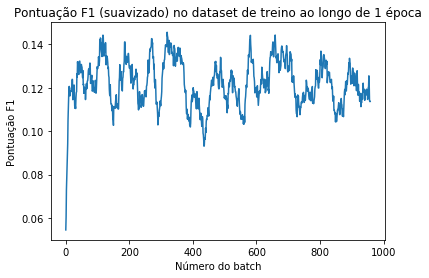

<Figure size 432x288 with 0 Axes>

In [29]:
f1_smooth = smooth(f1, 20)
plt.plot(f1_smooth[:-20])
plt.title("Pontuação F1 (suavizado) no dataset de treino ao longo de 1 época")
plt.xlabel("Número do batch")
plt.ylabel("Pontuação F1")

plt.show()
plt.savefig("plot")

ValueError: x and y must have same first dimension, but have shapes (8,) and (174,)

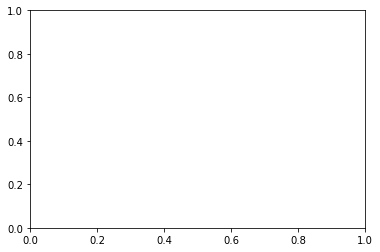

In [30]:
x = range(1,num_epochs+1)
y=f1_e
plt.plot(x, y)
plt.title("Pontuação F1 no dataset de teste ao longo de 8 épocas")
plt.xlabel("Época")
plt.ylabel("Pontuação F1")

plt.show()

In [ ]:
x = range(1,num_epochs+1)
y=losses_e
plt.plot(x, y)
plt.title("Perda no dataset de teste ao longo de 8 épocas")
plt.xlabel("Época")
plt.ylabel("Perda")

plt.show()

In [ ]:
x = range(1,num_epochs+1)
y=losses_t
plt.plot(x, y)
plt.title("Perda no dataset de treino ao longo de 8 épocas")
plt.xlabel("Época")
plt.ylabel("Perda")

plt.show()

In [ ]:
import numpy as np

In [ ]:
np.mean(f1_t)

Melhor resultado ali na terceira época? Ainda assim, a mudança de performance é pífia, uma epoca (5 minutos de treino!) já tem um resultado ok. Da pra otimizar a brincadeira, mas a saida não parece ser por epochs. Ainda preciso investigar se o modelo ta com algum problema de aprendizado ou se ele realmente satura muito rapido